# SSD 模型

In [1]:
'''
SSD 模型.
'''

import numpy as np
from keras.models import Model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
import keras.backend as K

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

def build_model(image_size,
                n_classes,
                mode='training',
                l2_regularization=0.0,
                min_scale=0.1,
                max_scale=0.9,
                scales=None,
                aspect_ratios_global=[0.5, 1.0, 2.0],
                aspect_ratios_per_layer=None,
                two_boxes_for_ar1=True,
                steps=None,
                offsets=None,
                clip_boxes=False,
                variances=[1.0, 1.0, 1.0, 1.0],
                coords='centroids',
                normalize_coords=False,
                subtract_mean=None,
                divide_by_stddev=None,
                swap_channels=False,
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False):
    '''
    此模型包含 7 个卷积层, 其中 4 个预测层, 预测层从第 4, 5, 6, 和 7 层做预测.

    Arguments:
        image_size (tuple): The input image size in the format `(height, width, channels)`.
        n_classes (int): The number of positive classes: 5.
        mode (str, optional): One of 'training', 'inference' and 'inference_fast'. In 'training' mode,
            the model outputs the raw prediction tensor, while in 'inference' and 'inference_fast' modes,
            the raw predictions are decoded into absolute coordinates and filtered via confidence thresholding,
            non-maximum suppression, and top-k filtering. The difference between latter two modes is that
            'inference' follows the exact procedure of the original Caffe implementation, while
            'inference_fast' uses a faster prediction decoding procedure.
        l2_regularization (float, optional): The L2-regularization rate. Applies to all convolutional layers.
        min_scale (float, optional): The smallest scaling factor for the size of the anchor boxes as a fraction
            of the shorter side of the input images.
        max_scale (float, optional): The largest scaling factor for the size of the anchor boxes as a fraction
            of the shorter side of the input images. All scaling factors between the smallest and the
            largest will be linearly interpolated. Note that the second to last of the linearly interpolated
            scaling factors will actually be the scaling factor for the last predictor layer, while the last
            scaling factor is used for the second box for aspect ratio 1 in the last predictor layer
            if `two_boxes_for_ar1` is `True`.
        scales (list, optional): A list of floats containing scaling factors per convolutional predictor layer.
            This list must be one element longer than the number of predictor layers. The first `k` elements are the
            scaling factors for the `k` predictor layers, while the last element is used for the second box
            for aspect ratio 1 in the last predictor layer if `two_boxes_for_ar1` is `True`. This additional
            last scaling factor must be passed either way, even if it is not being used. If a list is passed,
            this argument overrides `min_scale` and `max_scale`. All scaling factors must be greater than zero.
        aspect_ratios_global (list, optional): The list of aspect ratios for which anchor boxes are to be
            generated. This list is valid for all predictor layers. The original implementation uses more aspect ratios
            for some predictor layers and fewer for others. If you want to do that, too, then use the next argument instead.
        aspect_ratios_per_layer (list, optional): A list containing one aspect ratio list for each predictor layer.
            This allows you to set the aspect ratios for each predictor layer individually. If a list is passed,
            it overrides `aspect_ratios_global`.
        two_boxes_for_ar1 (bool, optional): Only relevant for aspect ratio lists that contain 1. Will be ignored otherwise.
            If `True`, two anchor boxes will be generated for aspect ratio 1. The first will be generated
            using the scaling factor for the respective layer, the second one will be generated using
            geometric mean of said scaling factor and next bigger scaling factor.
        steps (list, optional): `None` or a list with as many elements as there are predictor layers. The elements can be
            either ints/floats or tuples of two ints/floats. These numbers represent for each predictor layer how many
            pixels apart the anchor box center points should be vertically and horizontally along the spatial grid over
            the image. If the list contains ints/floats, then that value will be used for both spatial dimensions.
            If the list contains tuples of two ints/floats, then they represent `(step_height, step_width)`.
            If no steps are provided, then they will be computed such that the anchor box center points will form an
            equidistant grid within the image dimensions.
        offsets (list, optional): `None` or a list with as many elements as there are predictor layers. The elements can be
            either floats or tuples of two floats. These numbers represent for each predictor layer how many
            pixels from the top and left boarders of the image the top-most and left-most anchor box center points should be
            as a fraction of `steps`. The last bit is important: The offsets are not absolute pixel values, but fractions
            of the step size specified in the `steps` argument. If the list contains floats, then that value will
            be used for both spatial dimensions. If the list contains tuples of two floats, then they represent
            `(vertical_offset, horizontal_offset)`. If no offsets are provided, then they will default to 0.5 of the step size,
            which is also the recommended setting.
        clip_boxes (bool, optional): If `True`, clips the anchor box coordinates to stay within image boundaries.
        variances (list, optional): A list of 4 floats >0. The anchor box offset for each coordinate will be divided by
            its respective variance value.
        coords (str, optional): The box coordinate format to be used internally by the model (i.e. this is not the input format
            of the ground truth labels). Can be either 'centroids' for the format `(cx, cy, w, h)` (box center coordinates, width,
            and height), 'minmax' for the format `(xmin, xmax, ymin, ymax)`, or 'corners' for the format `(xmin, ymin, xmax, ymax)`.
        normalize_coords (bool, optional): Set to `True` if the model is supposed to use relative instead of absolute coordinates,
            i.e. if the model predicts box coordinates within [0,1] instead of absolute coordinates.
        subtract_mean (array-like, optional): `None` or an array-like object of integers or floating point values
            of any shape that is broadcast-compatible with the image shape. The elements of this array will be
            subtracted from the image pixel intensity values. For example, pass a list of three integers
            to perform per-channel mean normalization for color images.
        divide_by_stddev (array-like, optional): `None` or an array-like object of non-zero integers or
            floating point values of any shape that is broadcast-compatible with the image shape. The image pixel
            intensity values will be divided by the elements of this array. For example, pass a list
            of three integers to perform per-channel standard deviation normalization for color images.
        swap_channels (list, optional): Either `False` or a list of integers representing the desired order in which the input
            image channels should be swapped.
        confidence_thresh (float, optional): A float in [0,1), the minimum classification confidence in a specific
            positive class in order to be considered for the non-maximum suppression stage for the respective class.
            A lower value will result in a larger part of the selection process being done by the non-maximum suppression
            stage, while a larger value will result in a larger part of the selection process happening in the confidence
            thresholding stage.
        iou_threshold (float, optional): A float in [0,1]. All boxes that have a Jaccard similarity of greater than `iou_threshold`
            with a locally maximal box will be removed from the set of predictions for a given class, where 'maximal' refers
            to the box's confidence score.
        top_k (int, optional): The number of highest scoring predictions to be kept for each batch item after the
            non-maximum suppression stage.
        nms_max_output_size (int, optional): The maximal number of predictions that will be left over after the NMS stage.
        return_predictor_sizes (bool, optional): If `True`, this function not only returns the model, but also
            a list containing the spatial dimensions of the predictor layers. This isn't strictly necessary since
            you can always get their sizes easily via the Keras API, but it's convenient and less error-prone
            to get them this way. They are only relevant for training anyway (SSDBoxEncoder needs to know the
            spatial dimensions of the predictor layers), for inference you don't need them.

    Returns:
        model: The Keras SSD model.
        predictor_sizes (optional): A Numpy array containing the `(height, width)` portion
            of the output tensor shape for each convolutional predictor layer. During
            training, the generator function needs this in order to transform
            the ground truth labels into tensors of identical structure as the
            output tensors of the model, which is in turn needed for the cost
            function.

    References:
        https://arxiv.org/abs/1512.02325v5
    '''

    n_predictor_layers = 4 # The number of predictor conv layers in the network
    n_classes += 1 # Account for the background class.
    l2_reg = l2_regularization # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ############################################################################
    # Get a few exceptions out of the way.
    ############################################################################

    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    if len(variances) != 4: # We need one variance value for each of the four box coordinates
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")

    ############################################################################
    # Compute the anchor box parameters.
    ############################################################################

    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    ############################################################################
    # Define functions for the Lambda layers below.
    ############################################################################

    def identity_layer(tensor):
        return tensor

    def input_mean_normalization(tensor):
        return tensor - np.array(subtract_mean)

    def input_stddev_normalization(tensor):
        return tensor / np.array(divide_by_stddev)

    def input_channel_swap(tensor):
        if len(swap_channels) == 3:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]]], axis=-1)
        elif len(swap_channels) == 4:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]], tensor[...,swap_channels[3]]], axis=-1)

    ############################################################################
    # Build the network.
    ############################################################################

    x = Input(shape=(img_height, img_width, img_channels))
    x1 = Lambda(identity_layer,output_shape=(img_height, img_width, img_channels),name='identity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(input_mean_normalization,output_shape=(img_height, img_width, img_channels),name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(input_stddev_normalization,output_shape=(img_height, img_width, img_channels),name='input_stddev_normalization')(x1)
    
    conv1 = Conv2D(32,(5,5),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv1')(x1)#,kernel_regularize=l2(l2_reg)
    conv1 = BatchNormalization(axis=3,momentum=0.99,name='bn1')(conv1)
    conv1 = ELU(name='elu1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2),name='pool1')(conv1)
    
    conv2 = Conv2D(48,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv2')(pool1)
    conv2 = BatchNormalization(axis=3,momentum=0.99,name='bn2')(conv2)
    conv2 = ELU(name='elu2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2),name='pool2')(conv2)
    
    conv3 = Conv2D(64,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv3')(pool2)
    conv3 = BatchNormalization(axis=3,momentum=0.99,name='bn3')(conv3)
    conv3 = ELU(name='elu3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2),name='pool3')(conv3)
    
    conv4 = Conv2D(64,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv4')(pool3)
    conv4 = BatchNormalization(axis=3,momentum=0.99,name='bn4')(conv4)
    conv4 = ELU(name='elu4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2),name='pool4')(conv4)
    
    conv5 = Conv2D(48,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv5')(pool4)
    conv5 = BatchNormalization(axis=3,momentum=0.99,name='bn5')(conv5)
    conv5 = ELU(name='elu5')(conv5)
    pool5 = MaxPooling2D(pool_size=(2,2),name='pool5')(conv5)
    
    conv6 = Conv2D(48,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv6')(pool5)
    conv6 = BatchNormalization(axis=3,momentum=0.99,name='bn6')(conv6)
    conv6 = ELU(name='elu6')(conv6)
    pool6 = MaxPooling2D(pool_size=(2,2),name='pool6')(conv6)
    
    conv7 = Conv2D(32,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='conv7')(pool6)
    conv7 = BatchNormalization(axis=3,momentum=0.99,name='bn7')(conv7)
    conv7 = ELU(name='elu7')(conv7)
    
    classes4 = Conv2D(n_boxes[0]*n_classes,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='classes4')(conv4)
    classes5 = Conv2D(n_boxes[1]*n_classes,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='classes5')(conv5)
    classes6 = Conv2D(n_boxes[2]*n_classes,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='classes6')(conv6)
    classes7 = Conv2D(n_boxes[3]*n_classes,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='classes7')(conv7)
    
    boxes4 = Conv2D(n_boxes[0]*4,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='boxes4')(conv4)
    boxes5 = Conv2D(n_boxes[0]*4,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='boxes5')(conv5)
    boxes6 = Conv2D(n_boxes[0]*4,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='boxes6')(conv6)
    boxes7 = Conv2D(n_boxes[0]*4,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',name='boxes7')(conv7)
    
    
    anchors4 = AnchorBoxes(img_height, img_width,
                           this_scale=scales[0],next_scale=scales[1],aspect_ratios = aspect_ratios[0],this_steps=steps[0],this_offsets = offsets[0],
                           clip_boxes = clip_boxes,variances = variances,coords=coords,
                           normalize_coords=normalize_coords,two_boxes_for_ar1 = two_boxes_for_ar1,name='anchors4')(boxes4)
    anchors5 = AnchorBoxes(img_height, img_width,
                           this_scale=scales[1],next_scale=scales[2],aspect_ratios = aspect_ratios[1],this_steps=steps[1],this_offsets = offsets[1],
                           clip_boxes = clip_boxes,variances = variances,coords=coords,
                           normalize_coords=normalize_coords,two_boxes_for_ar1 = two_boxes_for_ar1,name='anchors5')(boxes5)
    anchors6 = AnchorBoxes(img_height, img_width,
                           this_scale=scales[2],next_scale=scales[3],aspect_ratios = aspect_ratios[2],this_steps=steps[2],this_offsets = offsets[2],
                           clip_boxes = clip_boxes,variances = variances,coords=coords,
                           normalize_coords=normalize_coords,two_boxes_for_ar1 = two_boxes_for_ar1,name='anchors6')(boxes6)
    anchors7 = AnchorBoxes(img_height, img_width,
                           this_scale=scales[3],next_scale=scales[4],aspect_ratios = aspect_ratios[3],this_steps=steps[3],this_offsets = offsets[3],
                           clip_boxes = clip_boxes,variances = variances,coords=coords,
                           normalize_coords=normalize_coords,two_boxes_for_ar1 = two_boxes_for_ar1,name='anchors7')(boxes7)
    classes4_reshaped = Reshape((-1,n_classes),name='classes4_reshaped')(classes4)
    classes5_reshaped = Reshape((-1,n_classes),name='classes5_reshaped')(classes5)
    classes6_reshaped = Reshape((-1,n_classes),name='classes6_reshaped')(classes6)
    classes7_reshaped = Reshape((-1,n_classes),name='classes7_reshaped')(classes7)
    
    boxes4_reshaped = Reshape((-1,4),name='boxes4_reshaped')(boxes4)
    boxes5_reshaped = Reshape((-1,4),name='boxes5_reshaped')(boxes5)
    boxes6_reshaped = Reshape((-1,4),name='boxes6_reshaped')(boxes6)
    boxes7_reshaped = Reshape((-1,4),name='boxes7_reshaped')(boxes7)
    
    anchors4_reshaped = Reshape((-1,8),name='anchors4_reshaped')(anchors4)
    anchors5_reshaped = Reshape((-1,8),name='anchors5_reshaped')(anchors5)
    anchors6_reshaped = Reshape((-1,8),name='anchors6_reshaped')(anchors6)
    anchors7_reshaped = Reshape((-1,8),name='anchors7_reshaped')(anchors7)
    
    classes_concat = Concatenate(axis=1,name='classes_concat')([classes4_reshaped,classes5_reshaped,classes6_reshaped,classes7_reshaped])
    boxes_concat = Concatenate(axis=1,name='boxes_concat')([boxes4_reshaped,boxes5_reshaped,boxes6_reshaped,boxes7_reshaped])
    anchors_concat = Concatenate(axis=1,name='anchors_concat')([anchors4_reshaped,anchors5_reshaped,anchors6_reshaped,anchors7_reshaped])
    
    classes_softmax = Activation('softmax',name='classes_softmax')(classes_concat)
    predictions = Concatenate(axis=2,name='predictions')([classes_softmax,boxes_concat,anchors_concat])
    if mode == 'training':
        model = Model(inputs=x, outputs=predictions)
    elif mode == 'inference':
        decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                               iou_threshold=iou_threshold,
                                               top_k=top_k,
                                               nms_max_output_size=nms_max_output_size,
                                               coords=coords,
                                               normalize_coords=normalize_coords,
                                               img_height=img_height,
                                               img_width=img_width,
                                               name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    elif mode == 'inference_fast':
        decoded_predictions = DecodeDetectionsFast(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    else:
        raise ValueError("`mode` must be one of 'training', 'inference' or 'inference_fast', but received '{}'.".format(mode))

    if return_predictor_sizes:
        # The spatial dimensions are the same for the `classes` and `boxes` predictor layers.
        predictor_sizes = np.array([classes4._keras_shape[1:3],
                                    classes5._keras_shape[1:3],
                                    classes6._keras_shape[1:3],
                                    classes7._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model


Using TensorFlow backend.


# 训练

训练集的图像数量:	 18000
validation集的图像数量	  4241
Epoch 1/10


 309/1000 [========>.....................] - ETA: 1:23:39 - loss: 27.044 - ETA: 43:18 - loss: 24.0195  - ETA: 29:50 - loss: 21.896 - ETA: 23:06 - loss: 20.540 - ETA: 19:58 - loss: 19.675 - ETA: 18:56 - loss: 18.814 - ETA: 17:57 - loss: 18.069 - ETA: 17:26 - loss: 17.436 - ETA: 17:08 - loss: 16.922 - ETA: 16:56 - loss: 16.386 - ETA: 16:23 - loss: 15.924 - ETA: 16:03 - loss: 15.489 - ETA: 15:52 - loss: 15.088 - ETA: 15:36 - loss: 14.728 - ETA: 15:19 - loss: 14.378 - ETA: 15:02 - loss: 14.068 - ETA: 14:55 - loss: 13.764 - ETA: 14:52 - loss: 13.475 - ETA: 14:45 - loss: 13.210 - ETA: 14:41 - loss: 12.975 - ETA: 14:38 - loss: 12.745 - ETA: 14:41 - loss: 12.534 - ETA: 14:35 - loss: 12.331 - ETA: 14:31 - loss: 12.141 - ETA: 14:26 - loss: 11.963 - ETA: 14:21 - loss: 11.793 - ETA: 14:18 - loss: 11.628 - ETA: 14:09 - loss: 11.475 - ETA: 14:06 - loss: 11.330 - ETA: 14:04 - loss: 11.188 - ETA: 13:59 - loss: 11.057 - ETA: 13:57 - loss: 10.936 - ETA: 13:55 - loss: 10.823 - ETA: 13:54 - loss: 10.702 -

 623/1000 [=================>............] - ETA: 9:12 - loss: 4.630 - ETA: 9:11 - loss: 4.625 - ETA: 9:10 - loss: 4.620 - ETA: 9:10 - loss: 4.615 - ETA: 9:09 - loss: 4.610 - ETA: 9:08 - loss: 4.606 - ETA: 9:07 - loss: 4.601 - ETA: 9:06 - loss: 4.597 - ETA: 9:06 - loss: 4.592 - ETA: 9:05 - loss: 4.588 - ETA: 9:04 - loss: 4.583 - ETA: 9:03 - loss: 4.579 - ETA: 9:02 - loss: 4.575 - ETA: 9:02 - loss: 4.570 - ETA: 9:01 - loss: 4.565 - ETA: 9:00 - loss: 4.560 - ETA: 8:59 - loss: 4.555 - ETA: 8:57 - loss: 4.551 - ETA: 8:56 - loss: 4.546 - ETA: 8:56 - loss: 4.542 - ETA: 8:55 - loss: 4.538 - ETA: 8:54 - loss: 4.533 - ETA: 8:53 - loss: 4.528 - ETA: 8:52 - loss: 4.523 - ETA: 8:51 - loss: 4.519 - ETA: 8:51 - loss: 4.515 - ETA: 8:50 - loss: 4.510 - ETA: 8:49 - loss: 4.505 - ETA: 8:48 - loss: 4.501 - ETA: 8:47 - loss: 4.497 - ETA: 8:46 - loss: 4.493 - ETA: 8:45 - loss: 4.488 - ETA: 8:44 - loss: 4.484 - ETA: 8:43 - loss: 4.480 - ETA: 8:42 - loss: 4.476 - ETA: 8:41 - loss: 4.473 - ETA: 8:40 - loss: 4

 938/1000 [===========================>..] - ETA: 4:51 - loss: 3.829 - ETA: 4:50 - loss: 3.827 - ETA: 4:49 - loss: 3.826 - ETA: 4:48 - loss: 3.824 - ETA: 4:47 - loss: 3.823 - ETA: 4:47 - loss: 3.822 - ETA: 4:46 - loss: 3.821 - ETA: 4:45 - loss: 3.820 - ETA: 4:44 - loss: 3.818 - ETA: 4:43 - loss: 3.817 - ETA: 4:43 - loss: 3.815 - ETA: 4:42 - loss: 3.814 - ETA: 4:41 - loss: 3.812 - ETA: 4:40 - loss: 3.811 - ETA: 4:39 - loss: 3.809 - ETA: 4:39 - loss: 3.808 - ETA: 4:38 - loss: 3.807 - ETA: 4:37 - loss: 3.806 - ETA: 4:36 - loss: 3.804 - ETA: 4:35 - loss: 3.802 - ETA: 4:34 - loss: 3.801 - ETA: 4:34 - loss: 3.799 - ETA: 4:33 - loss: 3.798 - ETA: 4:32 - loss: 3.797 - ETA: 4:31 - loss: 3.795 - ETA: 4:30 - loss: 3.794 - ETA: 4:30 - loss: 3.793 - ETA: 4:29 - loss: 3.792 - ETA: 4:28 - loss: 3.791 - ETA: 4:27 - loss: 3.790 - ETA: 4:27 - loss: 3.789 - ETA: 4:26 - loss: 3.787 - ETA: 4:25 - loss: 3.786 - ETA: 4:24 - loss: 3.785 - ETA: 4:23 - loss: 3.783 - ETA: 4:23 - loss: 3.782 - ETA: 4:22 - loss: 3

1000/1000 [==============================] - ETA: 46s - loss: 3.52 - ETA: 45s - loss: 3.52 - ETA: 44s - loss: 3.52 - ETA: 43s - loss: 3.52 - ETA: 43s - loss: 3.52 - ETA: 42s - loss: 3.52 - ETA: 41s - loss: 3.52 - ETA: 40s - loss: 3.52 - ETA: 40s - loss: 3.52 - ETA: 39s - loss: 3.52 - ETA: 38s - loss: 3.52 - ETA: 37s - loss: 3.52 - ETA: 37s - loss: 3.52 - ETA: 36s - loss: 3.52 - ETA: 35s - loss: 3.52 - ETA: 34s - loss: 3.51 - ETA: 34s - loss: 3.51 - ETA: 33s - loss: 3.51 - ETA: 32s - loss: 3.51 - ETA: 31s - loss: 3.51 - ETA: 31s - loss: 3.51 - ETA: 30s - loss: 3.51 - ETA: 29s - loss: 3.51 - ETA: 28s - loss: 3.51 - ETA: 28s - loss: 3.51 - ETA: 27s - loss: 3.51 - ETA: 26s - loss: 3.51 - ETA: 25s - loss: 3.51 - ETA: 24s - loss: 3.51 - ETA: 24s - loss: 3.51 - ETA: 23s - loss: 3.50 - ETA: 22s - loss: 3.50 - ETA: 21s - loss: 3.50 - ETA: 21s - loss: 3.50 - ETA: 20s - loss: 3.50 - ETA: 19s - loss: 3.50 - ETA: 18s - loss: 3.50 - ETA: 18s - loss: 3.50 - ETA: 17s - loss: 3.50 - ETA: 16s - loss: 3.

 314/1000 [========>.....................] - ETA: 2:32 - loss: 2.882 - ETA: 2:36 - loss: 2.836 - ETA: 2:39 - loss: 2.879 - ETA: 2:44 - loss: 2.874 - ETA: 2:47 - loss: 2.839 - ETA: 2:49 - loss: 2.848 - ETA: 2:49 - loss: 2.857 - ETA: 2:50 - loss: 2.843 - ETA: 2:49 - loss: 2.885 - ETA: 2:50 - loss: 2.876 - ETA: 2:50 - loss: 2.882 - ETA: 2:50 - loss: 2.884 - ETA: 3:04 - loss: 2.885 - ETA: 4:01 - loss: 2.874 - ETA: 4:37 - loss: 2.878 - ETA: 5:00 - loss: 2.876 - ETA: 5:24 - loss: 2.878 - ETA: 5:49 - loss: 2.878 - ETA: 6:10 - loss: 2.874 - ETA: 6:24 - loss: 2.885 - ETA: 6:31 - loss: 2.873 - ETA: 6:45 - loss: 2.900 - ETA: 6:57 - loss: 2.896 - ETA: 7:06 - loss: 2.892 - ETA: 7:16 - loss: 2.896 - ETA: 7:25 - loss: 2.890 - ETA: 7:32 - loss: 2.889 - ETA: 7:38 - loss: 2.882 - ETA: 7:42 - loss: 2.879 - ETA: 7:53 - loss: 2.876 - ETA: 7:58 - loss: 2.890 - ETA: 8:07 - loss: 2.890 - ETA: 8:12 - loss: 2.893 - ETA: 8:18 - loss: 2.896 - ETA: 8:21 - loss: 2.894 - ETA: 8:23 - loss: 2.892 - ETA: 8:30 - loss: 2

 628/1000 [=================>............] - ETA: 6:37 - loss: 2.890 - ETA: 6:36 - loss: 2.891 - ETA: 6:35 - loss: 2.891 - ETA: 6:35 - loss: 2.891 - ETA: 6:34 - loss: 2.891 - ETA: 6:33 - loss: 2.890 - ETA: 6:33 - loss: 2.890 - ETA: 6:32 - loss: 2.890 - ETA: 6:31 - loss: 2.891 - ETA: 6:31 - loss: 2.890 - ETA: 6:30 - loss: 2.890 - ETA: 6:29 - loss: 2.890 - ETA: 6:29 - loss: 2.890 - ETA: 6:28 - loss: 2.890 - ETA: 6:28 - loss: 2.889 - ETA: 6:27 - loss: 2.890 - ETA: 6:26 - loss: 2.890 - ETA: 6:26 - loss: 2.889 - ETA: 6:25 - loss: 2.890 - ETA: 6:24 - loss: 2.889 - ETA: 6:24 - loss: 2.889 - ETA: 6:23 - loss: 2.889 - ETA: 6:22 - loss: 2.888 - ETA: 6:22 - loss: 2.888 - ETA: 6:21 - loss: 2.887 - ETA: 6:20 - loss: 2.888 - ETA: 6:20 - loss: 2.887 - ETA: 6:19 - loss: 2.887 - ETA: 6:18 - loss: 2.886 - ETA: 6:18 - loss: 2.886 - ETA: 6:17 - loss: 2.887 - ETA: 6:16 - loss: 2.886 - ETA: 6:16 - loss: 2.886 - ETA: 6:15 - loss: 2.885 - ETA: 6:15 - loss: 2.884 - ETA: 6:14 - loss: 2.885 - ETA: 6:13 - loss: 2

 946/1000 [===========================>..] - ETA: 3:26 - loss: 2.847 - ETA: 3:25 - loss: 2.847 - ETA: 3:25 - loss: 2.847 - ETA: 3:24 - loss: 2.847 - ETA: 3:24 - loss: 2.847 - ETA: 3:23 - loss: 2.847 - ETA: 3:22 - loss: 2.846 - ETA: 3:22 - loss: 2.846 - ETA: 3:21 - loss: 2.846 - ETA: 3:21 - loss: 2.846 - ETA: 3:20 - loss: 2.845 - ETA: 3:20 - loss: 2.846 - ETA: 3:19 - loss: 2.846 - ETA: 3:19 - loss: 2.846 - ETA: 3:18 - loss: 2.846 - ETA: 3:17 - loss: 2.846 - ETA: 3:17 - loss: 2.846 - ETA: 3:16 - loss: 2.845 - ETA: 3:16 - loss: 2.845 - ETA: 3:15 - loss: 2.845 - ETA: 3:15 - loss: 2.845 - ETA: 3:14 - loss: 2.845 - ETA: 3:13 - loss: 2.845 - ETA: 3:13 - loss: 2.844 - ETA: 3:12 - loss: 2.844 - ETA: 3:12 - loss: 2.845 - ETA: 3:11 - loss: 2.845 - ETA: 3:11 - loss: 2.845 - ETA: 3:10 - loss: 2.844 - ETA: 3:09 - loss: 2.844 - ETA: 3:09 - loss: 2.844 - ETA: 3:08 - loss: 2.844 - ETA: 3:08 - loss: 2.844 - ETA: 3:07 - loss: 2.844 - ETA: 3:07 - loss: 2.844 - ETA: 3:06 - loss: 2.845 - ETA: 3:05 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.81 - ETA: 28s - loss: 2.81 - ETA: 27s - loss: 2.81 - ETA: 27s - loss: 2.81 - ETA: 26s - loss: 2.81 - ETA: 26s - loss: 2.81 - ETA: 25s - loss: 2.81 - ETA: 25s - loss: 2.81 - ETA: 24s - loss: 2.81 - ETA: 24s - loss: 2.81 - ETA: 23s - loss: 2.81 - ETA: 22s - loss: 2.81 - ETA: 22s - loss: 2.81 - ETA: 21s - loss: 2.81 - ETA: 21s - loss: 2.81 - ETA: 20s - loss: 2.81 - ETA: 20s - loss: 2.81 - ETA: 19s - loss: 2.81 - ETA: 19s - loss: 2.81 - ETA: 18s - loss: 2.81 - ETA: 18s - loss: 2.81 - ETA: 17s - loss: 2.81 - ETA: 16s - loss: 2.81 - ETA: 16s - loss: 2.81 - ETA: 15s - loss: 2.81 - ETA: 15s - loss: 2.81 - ETA: 14s - loss: 2.81 - ETA: 14s - loss: 2.81 - ETA: 13s - loss: 2.81 - ETA: 13s - loss: 2.80 - ETA: 12s - loss: 2.80 - ETA: 12s - loss: 2.80 - ETA: 11s - loss: 2.80 - ETA: 10s - loss: 2.80 - ETA: 10s - loss: 2.80 - ETA: 9s - loss: 2.8088 - ETA: 9s - loss: 2.808 - ETA: 8s - loss: 2.808 - ETA: 8s - loss: 2.808 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:47 - loss: 2.996 - ETA: 2:51 - loss: 2.834 - ETA: 2:53 - loss: 2.716 - ETA: 2:52 - loss: 2.689 - ETA: 2:53 - loss: 2.695 - ETA: 2:52 - loss: 2.672 - ETA: 2:53 - loss: 2.633 - ETA: 2:53 - loss: 2.673 - ETA: 2:53 - loss: 2.689 - ETA: 2:53 - loss: 2.712 - ETA: 2:53 - loss: 2.717 - ETA: 2:53 - loss: 2.745 - ETA: 2:52 - loss: 2.726 - ETA: 3:22 - loss: 2.713 - ETA: 4:04 - loss: 2.725 - ETA: 4:34 - loss: 2.712 - ETA: 5:05 - loss: 2.712 - ETA: 5:29 - loss: 2.736 - ETA: 5:41 - loss: 2.737 - ETA: 5:49 - loss: 2.743 - ETA: 5:56 - loss: 2.732 - ETA: 6:06 - loss: 2.749 - ETA: 6:12 - loss: 2.747 - ETA: 6:17 - loss: 2.741 - ETA: 6:21 - loss: 2.741 - ETA: 6:27 - loss: 2.735 - ETA: 6:30 - loss: 2.731 - ETA: 6:35 - loss: 2.736 - ETA: 6:40 - loss: 2.731 - ETA: 6:43 - loss: 2.727 - ETA: 6:49 - loss: 2.720 - ETA: 6:52 - loss: 2.721 - ETA: 6:55 - loss: 2.732 - ETA: 6:55 - loss: 2.723 - ETA: 6:57 - loss: 2.715 - ETA: 7:00 - loss: 2.712 - ETA: 7:03 - loss: 2

 628/1000 [=================>............] - ETA: 5:59 - loss: 2.689 - ETA: 5:59 - loss: 2.689 - ETA: 5:59 - loss: 2.690 - ETA: 5:58 - loss: 2.690 - ETA: 5:58 - loss: 2.690 - ETA: 5:57 - loss: 2.690 - ETA: 5:57 - loss: 2.690 - ETA: 5:56 - loss: 2.690 - ETA: 5:56 - loss: 2.689 - ETA: 5:55 - loss: 2.689 - ETA: 5:55 - loss: 2.689 - ETA: 5:54 - loss: 2.687 - ETA: 5:54 - loss: 2.687 - ETA: 5:53 - loss: 2.688 - ETA: 5:53 - loss: 2.688 - ETA: 5:52 - loss: 2.688 - ETA: 5:52 - loss: 2.688 - ETA: 5:52 - loss: 2.688 - ETA: 5:51 - loss: 2.688 - ETA: 5:51 - loss: 2.687 - ETA: 5:50 - loss: 2.686 - ETA: 5:50 - loss: 2.686 - ETA: 5:49 - loss: 2.686 - ETA: 5:49 - loss: 2.685 - ETA: 5:48 - loss: 2.685 - ETA: 5:48 - loss: 2.685 - ETA: 5:47 - loss: 2.685 - ETA: 5:47 - loss: 2.685 - ETA: 5:46 - loss: 2.685 - ETA: 5:46 - loss: 2.685 - ETA: 5:45 - loss: 2.684 - ETA: 5:45 - loss: 2.684 - ETA: 5:44 - loss: 2.686 - ETA: 5:44 - loss: 2.685 - ETA: 5:44 - loss: 2.686 - ETA: 5:43 - loss: 2.685 - ETA: 5:43 - loss: 2

 946/1000 [===========================>..] - ETA: 3:19 - loss: 2.663 - ETA: 3:19 - loss: 2.663 - ETA: 3:18 - loss: 2.663 - ETA: 3:18 - loss: 2.663 - ETA: 3:17 - loss: 2.662 - ETA: 3:17 - loss: 2.663 - ETA: 3:16 - loss: 2.663 - ETA: 3:15 - loss: 2.663 - ETA: 3:15 - loss: 2.663 - ETA: 3:14 - loss: 2.663 - ETA: 3:14 - loss: 2.663 - ETA: 3:13 - loss: 2.664 - ETA: 3:13 - loss: 2.663 - ETA: 3:12 - loss: 2.663 - ETA: 3:12 - loss: 2.663 - ETA: 3:11 - loss: 2.663 - ETA: 3:11 - loss: 2.663 - ETA: 3:10 - loss: 2.662 - ETA: 3:10 - loss: 2.662 - ETA: 3:09 - loss: 2.662 - ETA: 3:08 - loss: 2.663 - ETA: 3:08 - loss: 2.663 - ETA: 3:07 - loss: 2.662 - ETA: 3:07 - loss: 2.662 - ETA: 3:06 - loss: 2.662 - ETA: 3:06 - loss: 2.662 - ETA: 3:05 - loss: 2.662 - ETA: 3:05 - loss: 2.661 - ETA: 3:04 - loss: 2.661 - ETA: 3:04 - loss: 2.661 - ETA: 3:03 - loss: 2.661 - ETA: 3:03 - loss: 2.661 - ETA: 3:02 - loss: 2.660 - ETA: 3:02 - loss: 2.660 - ETA: 3:01 - loss: 2.660 - ETA: 3:01 - loss: 2.660 - ETA: 3:00 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.62 - ETA: 28s - loss: 2.62 - ETA: 27s - loss: 2.62 - ETA: 26s - loss: 2.62 - ETA: 26s - loss: 2.62 - ETA: 25s - loss: 2.62 - ETA: 25s - loss: 2.62 - ETA: 24s - loss: 2.62 - ETA: 24s - loss: 2.62 - ETA: 23s - loss: 2.62 - ETA: 23s - loss: 2.62 - ETA: 22s - loss: 2.62 - ETA: 22s - loss: 2.62 - ETA: 21s - loss: 2.62 - ETA: 21s - loss: 2.62 - ETA: 20s - loss: 2.62 - ETA: 19s - loss: 2.62 - ETA: 19s - loss: 2.62 - ETA: 18s - loss: 2.62 - ETA: 18s - loss: 2.62 - ETA: 17s - loss: 2.62 - ETA: 17s - loss: 2.62 - ETA: 16s - loss: 2.62 - ETA: 16s - loss: 2.62 - ETA: 15s - loss: 2.62 - ETA: 15s - loss: 2.62 - ETA: 14s - loss: 2.62 - ETA: 14s - loss: 2.62 - ETA: 13s - loss: 2.62 - ETA: 12s - loss: 2.62 - ETA: 12s - loss: 2.62 - ETA: 11s - loss: 2.62 - ETA: 11s - loss: 2.62 - ETA: 10s - loss: 2.62 - ETA: 10s - loss: 2.62 - ETA: 9s - loss: 2.6247 - ETA: 9s - loss: 2.624 - ETA: 8s - loss: 2.624 - ETA: 8s - loss: 2.624 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:49 - loss: 2.719 - ETA: 2:57 - loss: 2.623 - ETA: 2:59 - loss: 2.572 - ETA: 3:01 - loss: 2.548 - ETA: 3:01 - loss: 2.486 - ETA: 3:00 - loss: 2.538 - ETA: 2:59 - loss: 2.511 - ETA: 3:00 - loss: 2.498 - ETA: 3:00 - loss: 2.486 - ETA: 2:59 - loss: 2.502 - ETA: 3:00 - loss: 2.497 - ETA: 3:00 - loss: 2.503 - ETA: 3:00 - loss: 2.488 - ETA: 3:21 - loss: 2.489 - ETA: 4:03 - loss: 2.499 - ETA: 4:41 - loss: 2.488 - ETA: 5:11 - loss: 2.495 - ETA: 5:33 - loss: 2.472 - ETA: 5:41 - loss: 2.461 - ETA: 5:50 - loss: 2.454 - ETA: 5:58 - loss: 2.472 - ETA: 6:06 - loss: 2.468 - ETA: 6:15 - loss: 2.474 - ETA: 6:22 - loss: 2.483 - ETA: 6:27 - loss: 2.495 - ETA: 6:32 - loss: 2.497 - ETA: 6:36 - loss: 2.506 - ETA: 6:41 - loss: 2.512 - ETA: 6:45 - loss: 2.530 - ETA: 6:48 - loss: 2.523 - ETA: 6:50 - loss: 2.524 - ETA: 6:52 - loss: 2.520 - ETA: 6:55 - loss: 2.513 - ETA: 6:57 - loss: 2.516 - ETA: 7:00 - loss: 2.521 - ETA: 7:02 - loss: 2.520 - ETA: 7:06 - loss: 2

 628/1000 [=================>............] - ETA: 6:03 - loss: 2.483 - ETA: 6:03 - loss: 2.483 - ETA: 6:02 - loss: 2.482 - ETA: 6:02 - loss: 2.482 - ETA: 6:01 - loss: 2.482 - ETA: 6:01 - loss: 2.481 - ETA: 6:00 - loss: 2.482 - ETA: 6:00 - loss: 2.483 - ETA: 5:59 - loss: 2.483 - ETA: 5:59 - loss: 2.483 - ETA: 5:58 - loss: 2.484 - ETA: 5:58 - loss: 2.484 - ETA: 5:57 - loss: 2.483 - ETA: 5:57 - loss: 2.483 - ETA: 5:56 - loss: 2.482 - ETA: 5:56 - loss: 2.482 - ETA: 5:55 - loss: 2.483 - ETA: 5:55 - loss: 2.484 - ETA: 5:54 - loss: 2.485 - ETA: 5:54 - loss: 2.485 - ETA: 5:53 - loss: 2.485 - ETA: 5:52 - loss: 2.485 - ETA: 5:52 - loss: 2.485 - ETA: 5:51 - loss: 2.485 - ETA: 5:51 - loss: 2.485 - ETA: 5:50 - loss: 2.486 - ETA: 5:50 - loss: 2.487 - ETA: 5:49 - loss: 2.487 - ETA: 5:49 - loss: 2.488 - ETA: 5:48 - loss: 2.488 - ETA: 5:48 - loss: 2.489 - ETA: 5:47 - loss: 2.489 - ETA: 5:47 - loss: 2.490 - ETA: 5:46 - loss: 2.489 - ETA: 5:46 - loss: 2.488 - ETA: 5:45 - loss: 2.488 - ETA: 5:44 - loss: 2

 946/1000 [===========================>..] - ETA: 3:19 - loss: 2.471 - ETA: 3:18 - loss: 2.470 - ETA: 3:18 - loss: 2.470 - ETA: 3:17 - loss: 2.470 - ETA: 3:17 - loss: 2.470 - ETA: 3:16 - loss: 2.470 - ETA: 3:16 - loss: 2.470 - ETA: 3:15 - loss: 2.470 - ETA: 3:14 - loss: 2.470 - ETA: 3:14 - loss: 2.469 - ETA: 3:13 - loss: 2.469 - ETA: 3:13 - loss: 2.469 - ETA: 3:12 - loss: 2.469 - ETA: 3:12 - loss: 2.469 - ETA: 3:11 - loss: 2.469 - ETA: 3:11 - loss: 2.469 - ETA: 3:10 - loss: 2.469 - ETA: 3:10 - loss: 2.469 - ETA: 3:09 - loss: 2.469 - ETA: 3:09 - loss: 2.468 - ETA: 3:08 - loss: 2.468 - ETA: 3:08 - loss: 2.468 - ETA: 3:07 - loss: 2.468 - ETA: 3:07 - loss: 2.468 - ETA: 3:06 - loss: 2.468 - ETA: 3:05 - loss: 2.468 - ETA: 3:05 - loss: 2.468 - ETA: 3:04 - loss: 2.468 - ETA: 3:04 - loss: 2.467 - ETA: 3:03 - loss: 2.467 - ETA: 3:03 - loss: 2.467 - ETA: 3:02 - loss: 2.466 - ETA: 3:02 - loss: 2.466 - ETA: 3:01 - loss: 2.466 - ETA: 3:01 - loss: 2.465 - ETA: 3:00 - loss: 2.465 - ETA: 2:59 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.45 - ETA: 28s - loss: 2.45 - ETA: 27s - loss: 2.45 - ETA: 26s - loss: 2.45 - ETA: 26s - loss: 2.45 - ETA: 25s - loss: 2.45 - ETA: 25s - loss: 2.45 - ETA: 24s - loss: 2.45 - ETA: 24s - loss: 2.45 - ETA: 23s - loss: 2.45 - ETA: 23s - loss: 2.45 - ETA: 22s - loss: 2.45 - ETA: 22s - loss: 2.45 - ETA: 21s - loss: 2.45 - ETA: 21s - loss: 2.45 - ETA: 20s - loss: 2.45 - ETA: 19s - loss: 2.45 - ETA: 19s - loss: 2.45 - ETA: 18s - loss: 2.45 - ETA: 18s - loss: 2.45 - ETA: 17s - loss: 2.45 - ETA: 17s - loss: 2.45 - ETA: 16s - loss: 2.45 - ETA: 16s - loss: 2.45 - ETA: 15s - loss: 2.45 - ETA: 15s - loss: 2.45 - ETA: 14s - loss: 2.45 - ETA: 14s - loss: 2.45 - ETA: 13s - loss: 2.45 - ETA: 12s - loss: 2.45 - ETA: 12s - loss: 2.45 - ETA: 11s - loss: 2.45 - ETA: 11s - loss: 2.45 - ETA: 10s - loss: 2.45 - ETA: 10s - loss: 2.45 - ETA: 9s - loss: 2.4520 - ETA: 9s - loss: 2.451 - ETA: 8s - loss: 2.451 - ETA: 8s - loss: 2.451 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:48 - loss: 2.829 - ETA: 2:52 - loss: 2.373 - ETA: 2:55 - loss: 2.396 - ETA: 2:56 - loss: 2.469 - ETA: 2:56 - loss: 2.456 - ETA: 2:56 - loss: 2.438 - ETA: 2:57 - loss: 2.402 - ETA: 2:56 - loss: 2.383 - ETA: 2:56 - loss: 2.379 - ETA: 2:56 - loss: 2.391 - ETA: 2:56 - loss: 2.382 - ETA: 2:56 - loss: 2.366 - ETA: 2:56 - loss: 2.364 - ETA: 3:19 - loss: 2.371 - ETA: 4:01 - loss: 2.379 - ETA: 4:36 - loss: 2.362 - ETA: 5:11 - loss: 2.370 - ETA: 5:35 - loss: 2.375 - ETA: 5:44 - loss: 2.376 - ETA: 5:53 - loss: 2.382 - ETA: 6:01 - loss: 2.388 - ETA: 6:10 - loss: 2.397 - ETA: 6:15 - loss: 2.392 - ETA: 6:21 - loss: 2.389 - ETA: 6:26 - loss: 2.384 - ETA: 6:31 - loss: 2.377 - ETA: 6:36 - loss: 2.367 - ETA: 6:42 - loss: 2.353 - ETA: 6:46 - loss: 2.350 - ETA: 6:50 - loss: 2.350 - ETA: 6:55 - loss: 2.352 - ETA: 6:59 - loss: 2.341 - ETA: 7:03 - loss: 2.341 - ETA: 7:06 - loss: 2.343 - ETA: 7:08 - loss: 2.341 - ETA: 7:12 - loss: 2.347 - ETA: 7:14 - loss: 2

 628/1000 [=================>............] - ETA: 6:07 - loss: 2.377 - ETA: 6:06 - loss: 2.376 - ETA: 6:05 - loss: 2.377 - ETA: 6:05 - loss: 2.377 - ETA: 6:05 - loss: 2.379 - ETA: 6:04 - loss: 2.378 - ETA: 6:04 - loss: 2.379 - ETA: 6:03 - loss: 2.379 - ETA: 6:03 - loss: 2.378 - ETA: 6:02 - loss: 2.377 - ETA: 6:01 - loss: 2.377 - ETA: 6:01 - loss: 2.377 - ETA: 6:00 - loss: 2.376 - ETA: 6:00 - loss: 2.377 - ETA: 5:59 - loss: 2.378 - ETA: 5:59 - loss: 2.378 - ETA: 5:58 - loss: 2.378 - ETA: 5:58 - loss: 2.378 - ETA: 5:57 - loss: 2.378 - ETA: 5:57 - loss: 2.378 - ETA: 5:56 - loss: 2.378 - ETA: 5:56 - loss: 2.377 - ETA: 5:55 - loss: 2.378 - ETA: 5:55 - loss: 2.378 - ETA: 5:54 - loss: 2.379 - ETA: 5:54 - loss: 2.379 - ETA: 5:53 - loss: 2.379 - ETA: 5:52 - loss: 2.378 - ETA: 5:52 - loss: 2.378 - ETA: 5:51 - loss: 2.379 - ETA: 5:51 - loss: 2.377 - ETA: 5:50 - loss: 2.378 - ETA: 5:50 - loss: 2.378 - ETA: 5:49 - loss: 2.379 - ETA: 5:49 - loss: 2.379 - ETA: 5:48 - loss: 2.378 - ETA: 5:48 - loss: 2

 946/1000 [===========================>..] - ETA: 3:19 - loss: 2.364 - ETA: 3:19 - loss: 2.364 - ETA: 3:18 - loss: 2.364 - ETA: 3:18 - loss: 2.364 - ETA: 3:17 - loss: 2.364 - ETA: 3:16 - loss: 2.363 - ETA: 3:16 - loss: 2.363 - ETA: 3:15 - loss: 2.363 - ETA: 3:15 - loss: 2.363 - ETA: 3:14 - loss: 2.363 - ETA: 3:14 - loss: 2.363 - ETA: 3:13 - loss: 2.362 - ETA: 3:13 - loss: 2.362 - ETA: 3:12 - loss: 2.363 - ETA: 3:12 - loss: 2.362 - ETA: 3:11 - loss: 2.362 - ETA: 3:11 - loss: 2.362 - ETA: 3:10 - loss: 2.362 - ETA: 3:10 - loss: 2.362 - ETA: 3:09 - loss: 2.361 - ETA: 3:08 - loss: 2.361 - ETA: 3:08 - loss: 2.362 - ETA: 3:07 - loss: 2.362 - ETA: 3:07 - loss: 2.362 - ETA: 3:06 - loss: 2.361 - ETA: 3:06 - loss: 2.361 - ETA: 3:05 - loss: 2.362 - ETA: 3:05 - loss: 2.361 - ETA: 3:04 - loss: 2.361 - ETA: 3:04 - loss: 2.361 - ETA: 3:03 - loss: 2.361 - ETA: 3:03 - loss: 2.361 - ETA: 3:02 - loss: 2.362 - ETA: 3:02 - loss: 2.362 - ETA: 3:01 - loss: 2.362 - ETA: 3:00 - loss: 2.362 - ETA: 3:00 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.34 - ETA: 28s - loss: 2.34 - ETA: 27s - loss: 2.34 - ETA: 27s - loss: 2.34 - ETA: 26s - loss: 2.34 - ETA: 25s - loss: 2.34 - ETA: 25s - loss: 2.34 - ETA: 24s - loss: 2.34 - ETA: 24s - loss: 2.34 - ETA: 23s - loss: 2.34 - ETA: 23s - loss: 2.34 - ETA: 22s - loss: 2.34 - ETA: 22s - loss: 2.34 - ETA: 21s - loss: 2.34 - ETA: 21s - loss: 2.34 - ETA: 20s - loss: 2.34 - ETA: 19s - loss: 2.34 - ETA: 19s - loss: 2.34 - ETA: 18s - loss: 2.34 - ETA: 18s - loss: 2.34 - ETA: 17s - loss: 2.34 - ETA: 17s - loss: 2.34 - ETA: 16s - loss: 2.34 - ETA: 16s - loss: 2.34 - ETA: 15s - loss: 2.34 - ETA: 15s - loss: 2.34 - ETA: 14s - loss: 2.34 - ETA: 14s - loss: 2.34 - ETA: 13s - loss: 2.34 - ETA: 12s - loss: 2.34 - ETA: 12s - loss: 2.34 - ETA: 11s - loss: 2.34 - ETA: 11s - loss: 2.34 - ETA: 10s - loss: 2.34 - ETA: 10s - loss: 2.34 - ETA: 9s - loss: 2.3432 - ETA: 9s - loss: 2.342 - ETA: 8s - loss: 2.343 - ETA: 8s - loss: 2.343 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:50 - loss: 2.161 - ETA: 2:54 - loss: 2.147 - ETA: 2:56 - loss: 2.236 - ETA: 2:58 - loss: 2.188 - ETA: 3:00 - loss: 2.187 - ETA: 3:00 - loss: 2.154 - ETA: 3:00 - loss: 2.131 - ETA: 3:00 - loss: 2.175 - ETA: 3:00 - loss: 2.174 - ETA: 3:00 - loss: 2.161 - ETA: 3:00 - loss: 2.179 - ETA: 3:00 - loss: 2.179 - ETA: 3:00 - loss: 2.248 - ETA: 3:21 - loss: 2.230 - ETA: 4:04 - loss: 2.227 - ETA: 4:40 - loss: 2.248 - ETA: 5:09 - loss: 2.243 - ETA: 5:31 - loss: 2.260 - ETA: 5:41 - loss: 2.279 - ETA: 5:53 - loss: 2.277 - ETA: 6:02 - loss: 2.259 - ETA: 6:11 - loss: 2.258 - ETA: 6:15 - loss: 2.250 - ETA: 6:23 - loss: 2.247 - ETA: 6:27 - loss: 2.232 - ETA: 6:34 - loss: 2.232 - ETA: 6:38 - loss: 2.237 - ETA: 6:43 - loss: 2.243 - ETA: 6:46 - loss: 2.241 - ETA: 6:52 - loss: 2.236 - ETA: 6:56 - loss: 2.246 - ETA: 6:59 - loss: 2.248 - ETA: 7:02 - loss: 2.248 - ETA: 7:04 - loss: 2.249 - ETA: 7:05 - loss: 2.253 - ETA: 7:11 - loss: 2.254 - ETA: 7:13 - loss: 2

 628/1000 [=================>............] - ETA: 6:07 - loss: 2.283 - ETA: 6:06 - loss: 2.284 - ETA: 6:06 - loss: 2.285 - ETA: 6:05 - loss: 2.284 - ETA: 6:05 - loss: 2.285 - ETA: 6:04 - loss: 2.284 - ETA: 6:04 - loss: 2.285 - ETA: 6:04 - loss: 2.284 - ETA: 6:03 - loss: 2.283 - ETA: 6:02 - loss: 2.282 - ETA: 6:02 - loss: 2.282 - ETA: 6:01 - loss: 2.282 - ETA: 6:01 - loss: 2.282 - ETA: 6:00 - loss: 2.282 - ETA: 6:00 - loss: 2.282 - ETA: 5:59 - loss: 2.282 - ETA: 5:59 - loss: 2.281 - ETA: 5:58 - loss: 2.281 - ETA: 5:58 - loss: 2.282 - ETA: 5:57 - loss: 2.283 - ETA: 5:57 - loss: 2.284 - ETA: 5:56 - loss: 2.284 - ETA: 5:56 - loss: 2.285 - ETA: 5:55 - loss: 2.285 - ETA: 5:55 - loss: 2.285 - ETA: 5:54 - loss: 2.286 - ETA: 5:53 - loss: 2.286 - ETA: 5:53 - loss: 2.287 - ETA: 5:52 - loss: 2.286 - ETA: 5:52 - loss: 2.286 - ETA: 5:51 - loss: 2.286 - ETA: 5:51 - loss: 2.287 - ETA: 5:50 - loss: 2.287 - ETA: 5:50 - loss: 2.288 - ETA: 5:49 - loss: 2.288 - ETA: 5:49 - loss: 2.287 - ETA: 5:48 - loss: 2

 946/1000 [===========================>..] - ETA: 3:25 - loss: 2.264 - ETA: 3:24 - loss: 2.264 - ETA: 3:24 - loss: 2.264 - ETA: 3:23 - loss: 2.264 - ETA: 3:23 - loss: 2.264 - ETA: 3:22 - loss: 2.264 - ETA: 3:22 - loss: 2.264 - ETA: 3:21 - loss: 2.264 - ETA: 3:21 - loss: 2.264 - ETA: 3:20 - loss: 2.264 - ETA: 3:19 - loss: 2.263 - ETA: 3:19 - loss: 2.263 - ETA: 3:18 - loss: 2.263 - ETA: 3:18 - loss: 2.263 - ETA: 3:17 - loss: 2.264 - ETA: 3:17 - loss: 2.263 - ETA: 3:16 - loss: 2.264 - ETA: 3:16 - loss: 2.263 - ETA: 3:15 - loss: 2.263 - ETA: 3:14 - loss: 2.263 - ETA: 3:14 - loss: 2.263 - ETA: 3:13 - loss: 2.263 - ETA: 3:13 - loss: 2.262 - ETA: 3:12 - loss: 2.262 - ETA: 3:12 - loss: 2.262 - ETA: 3:11 - loss: 2.262 - ETA: 3:11 - loss: 2.262 - ETA: 3:10 - loss: 2.262 - ETA: 3:09 - loss: 2.262 - ETA: 3:09 - loss: 2.263 - ETA: 3:08 - loss: 2.262 - ETA: 3:08 - loss: 2.262 - ETA: 3:07 - loss: 2.263 - ETA: 3:07 - loss: 2.263 - ETA: 3:06 - loss: 2.263 - ETA: 3:06 - loss: 2.263 - ETA: 3:05 - loss: 2

1000/1000 [==============================] - ETA: 29s - loss: 2.25 - ETA: 28s - loss: 2.25 - ETA: 28s - loss: 2.25 - ETA: 27s - loss: 2.25 - ETA: 27s - loss: 2.25 - ETA: 26s - loss: 2.25 - ETA: 26s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 20s - loss: 2.25 - ETA: 19s - loss: 2.25 - ETA: 19s - loss: 2.25 - ETA: 18s - loss: 2.25 - ETA: 18s - loss: 2.25 - ETA: 17s - loss: 2.25 - ETA: 17s - loss: 2.25 - ETA: 16s - loss: 2.25 - ETA: 16s - loss: 2.25 - ETA: 15s - loss: 2.25 - ETA: 14s - loss: 2.25 - ETA: 14s - loss: 2.25 - ETA: 13s - loss: 2.25 - ETA: 13s - loss: 2.25 - ETA: 12s - loss: 2.25 - ETA: 12s - loss: 2.25 - ETA: 11s - loss: 2.25 - ETA: 11s - loss: 2.25 - ETA: 10s - loss: 2.25 - ETA: 9s - loss: 2.2537 - ETA: 9s - loss: 2.253 - ETA: 8s - loss: 2.253 - ETA: 8s - loss: 2.254 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:46 - loss: 2.066 - ETA: 2:54 - loss: 2.181 - ETA: 2:57 - loss: 2.181 - ETA: 2:58 - loss: 2.219 - ETA: 2:59 - loss: 2.199 - ETA: 2:59 - loss: 2.220 - ETA: 2:59 - loss: 2.274 - ETA: 2:59 - loss: 2.261 - ETA: 2:59 - loss: 2.269 - ETA: 2:59 - loss: 2.246 - ETA: 2:59 - loss: 2.244 - ETA: 2:58 - loss: 2.231 - ETA: 2:58 - loss: 2.240 - ETA: 3:35 - loss: 2.248 - ETA: 4:17 - loss: 2.254 - ETA: 4:52 - loss: 2.255 - ETA: 5:19 - loss: 2.233 - ETA: 5:39 - loss: 2.252 - ETA: 5:49 - loss: 2.244 - ETA: 5:58 - loss: 2.242 - ETA: 6:08 - loss: 2.249 - ETA: 6:15 - loss: 2.252 - ETA: 6:21 - loss: 2.256 - ETA: 6:27 - loss: 2.239 - ETA: 6:35 - loss: 2.243 - ETA: 6:40 - loss: 2.228 - ETA: 6:43 - loss: 2.233 - ETA: 6:48 - loss: 2.237 - ETA: 6:51 - loss: 2.239 - ETA: 6:56 - loss: 2.245 - ETA: 6:59 - loss: 2.235 - ETA: 7:02 - loss: 2.239 - ETA: 7:07 - loss: 2.244 - ETA: 7:10 - loss: 2.237 - ETA: 7:14 - loss: 2.235 - ETA: 7:16 - loss: 2.236 - ETA: 7:20 - loss: 2

 628/1000 [=================>............] - ETA: 6:15 - loss: 2.218 - ETA: 6:14 - loss: 2.218 - ETA: 6:14 - loss: 2.218 - ETA: 6:13 - loss: 2.219 - ETA: 6:13 - loss: 2.219 - ETA: 6:12 - loss: 2.219 - ETA: 6:12 - loss: 2.219 - ETA: 6:11 - loss: 2.219 - ETA: 6:11 - loss: 2.218 - ETA: 6:10 - loss: 2.218 - ETA: 6:10 - loss: 2.219 - ETA: 6:09 - loss: 2.219 - ETA: 6:09 - loss: 2.219 - ETA: 6:08 - loss: 2.218 - ETA: 6:07 - loss: 2.218 - ETA: 6:07 - loss: 2.219 - ETA: 6:06 - loss: 2.218 - ETA: 6:06 - loss: 2.218 - ETA: 6:05 - loss: 2.218 - ETA: 6:05 - loss: 2.219 - ETA: 6:04 - loss: 2.218 - ETA: 6:03 - loss: 2.218 - ETA: 6:03 - loss: 2.217 - ETA: 6:03 - loss: 2.216 - ETA: 6:02 - loss: 2.216 - ETA: 6:02 - loss: 2.216 - ETA: 6:01 - loss: 2.217 - ETA: 6:00 - loss: 2.216 - ETA: 6:00 - loss: 2.216 - ETA: 6:00 - loss: 2.216 - ETA: 5:59 - loss: 2.217 - ETA: 5:59 - loss: 2.216 - ETA: 5:58 - loss: 2.216 - ETA: 5:58 - loss: 2.217 - ETA: 5:57 - loss: 2.216 - ETA: 5:56 - loss: 2.216 - ETA: 5:56 - loss: 2

 946/1000 [===========================>..] - ETA: 3:27 - loss: 2.199 - ETA: 3:26 - loss: 2.199 - ETA: 3:25 - loss: 2.199 - ETA: 3:25 - loss: 2.200 - ETA: 3:24 - loss: 2.200 - ETA: 3:24 - loss: 2.200 - ETA: 3:23 - loss: 2.200 - ETA: 3:23 - loss: 2.201 - ETA: 3:22 - loss: 2.201 - ETA: 3:21 - loss: 2.200 - ETA: 3:21 - loss: 2.200 - ETA: 3:20 - loss: 2.200 - ETA: 3:20 - loss: 2.200 - ETA: 3:19 - loss: 2.200 - ETA: 3:19 - loss: 2.200 - ETA: 3:18 - loss: 2.200 - ETA: 3:18 - loss: 2.200 - ETA: 3:17 - loss: 2.200 - ETA: 3:16 - loss: 2.200 - ETA: 3:16 - loss: 2.200 - ETA: 3:15 - loss: 2.200 - ETA: 3:15 - loss: 2.200 - ETA: 3:14 - loss: 2.200 - ETA: 3:14 - loss: 2.200 - ETA: 3:13 - loss: 2.200 - ETA: 3:12 - loss: 2.200 - ETA: 3:12 - loss: 2.200 - ETA: 3:11 - loss: 2.200 - ETA: 3:11 - loss: 2.200 - ETA: 3:10 - loss: 2.199 - ETA: 3:10 - loss: 2.199 - ETA: 3:09 - loss: 2.199 - ETA: 3:08 - loss: 2.198 - ETA: 3:08 - loss: 2.199 - ETA: 3:07 - loss: 2.198 - ETA: 3:07 - loss: 2.198 - ETA: 3:06 - loss: 2

1000/1000 [==============================] - ETA: 29s - loss: 2.19 - ETA: 28s - loss: 2.19 - ETA: 28s - loss: 2.19 - ETA: 27s - loss: 2.19 - ETA: 27s - loss: 2.19 - ETA: 26s - loss: 2.19 - ETA: 26s - loss: 2.19 - ETA: 25s - loss: 2.19 - ETA: 24s - loss: 2.19 - ETA: 24s - loss: 2.19 - ETA: 23s - loss: 2.19 - ETA: 23s - loss: 2.19 - ETA: 22s - loss: 2.19 - ETA: 22s - loss: 2.19 - ETA: 21s - loss: 2.19 - ETA: 21s - loss: 2.19 - ETA: 20s - loss: 2.19 - ETA: 19s - loss: 2.19 - ETA: 19s - loss: 2.19 - ETA: 18s - loss: 2.19 - ETA: 18s - loss: 2.19 - ETA: 17s - loss: 2.19 - ETA: 17s - loss: 2.19 - ETA: 16s - loss: 2.19 - ETA: 16s - loss: 2.19 - ETA: 15s - loss: 2.19 - ETA: 14s - loss: 2.19 - ETA: 14s - loss: 2.19 - ETA: 13s - loss: 2.19 - ETA: 13s - loss: 2.19 - ETA: 12s - loss: 2.19 - ETA: 12s - loss: 2.19 - ETA: 11s - loss: 2.19 - ETA: 11s - loss: 2.19 - ETA: 10s - loss: 2.19 - ETA: 9s - loss: 2.1953 - ETA: 9s - loss: 2.195 - ETA: 8s - loss: 2.195 - ETA: 8s - loss: 2.195 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:51 - loss: 2.215 - ETA: 2:52 - loss: 2.108 - ETA: 2:58 - loss: 2.045 - ETA: 2:59 - loss: 2.170 - ETA: 2:59 - loss: 2.099 - ETA: 2:59 - loss: 2.106 - ETA: 2:59 - loss: 2.165 - ETA: 2:59 - loss: 2.132 - ETA: 3:00 - loss: 2.137 - ETA: 2:59 - loss: 2.137 - ETA: 2:59 - loss: 2.160 - ETA: 2:58 - loss: 2.143 - ETA: 2:59 - loss: 2.158 - ETA: 3:35 - loss: 2.209 - ETA: 4:19 - loss: 2.238 - ETA: 4:51 - loss: 2.209 - ETA: 5:16 - loss: 2.207 - ETA: 5:35 - loss: 2.192 - ETA: 5:49 - loss: 2.204 - ETA: 6:01 - loss: 2.204 - ETA: 6:10 - loss: 2.207 - ETA: 6:21 - loss: 2.207 - ETA: 6:26 - loss: 2.190 - ETA: 6:29 - loss: 2.188 - ETA: 6:34 - loss: 2.185 - ETA: 6:38 - loss: 2.180 - ETA: 6:43 - loss: 2.170 - ETA: 6:47 - loss: 2.171 - ETA: 6:50 - loss: 2.160 - ETA: 6:52 - loss: 2.160 - ETA: 6:54 - loss: 2.151 - ETA: 6:56 - loss: 2.152 - ETA: 6:58 - loss: 2.157 - ETA: 7:01 - loss: 2.158 - ETA: 7:04 - loss: 2.153 - ETA: 7:07 - loss: 2.149 - ETA: 7:09 - loss: 2

 628/1000 [=================>............] - ETA: 6:03 - loss: 2.155 - ETA: 6:02 - loss: 2.156 - ETA: 6:02 - loss: 2.156 - ETA: 6:01 - loss: 2.155 - ETA: 6:01 - loss: 2.154 - ETA: 6:00 - loss: 2.153 - ETA: 6:00 - loss: 2.153 - ETA: 5:59 - loss: 2.153 - ETA: 5:59 - loss: 2.152 - ETA: 5:58 - loss: 2.152 - ETA: 5:58 - loss: 2.152 - ETA: 5:57 - loss: 2.152 - ETA: 5:57 - loss: 2.152 - ETA: 5:56 - loss: 2.153 - ETA: 5:56 - loss: 2.153 - ETA: 5:55 - loss: 2.152 - ETA: 5:55 - loss: 2.151 - ETA: 5:54 - loss: 2.153 - ETA: 5:54 - loss: 2.153 - ETA: 5:53 - loss: 2.152 - ETA: 5:53 - loss: 2.153 - ETA: 5:53 - loss: 2.153 - ETA: 5:52 - loss: 2.153 - ETA: 5:52 - loss: 2.153 - ETA: 5:51 - loss: 2.154 - ETA: 5:51 - loss: 2.153 - ETA: 5:50 - loss: 2.154 - ETA: 5:50 - loss: 2.155 - ETA: 5:49 - loss: 2.154 - ETA: 5:49 - loss: 2.154 - ETA: 5:48 - loss: 2.153 - ETA: 5:48 - loss: 2.153 - ETA: 5:47 - loss: 2.154 - ETA: 5:47 - loss: 2.152 - ETA: 5:46 - loss: 2.152 - ETA: 5:46 - loss: 2.152 - ETA: 5:45 - loss: 2

 946/1000 [===========================>..] - ETA: 3:19 - loss: 2.156 - ETA: 3:18 - loss: 2.156 - ETA: 3:18 - loss: 2.156 - ETA: 3:17 - loss: 2.156 - ETA: 3:17 - loss: 2.156 - ETA: 3:16 - loss: 2.157 - ETA: 3:16 - loss: 2.157 - ETA: 3:15 - loss: 2.157 - ETA: 3:15 - loss: 2.157 - ETA: 3:14 - loss: 2.156 - ETA: 3:14 - loss: 2.156 - ETA: 3:13 - loss: 2.156 - ETA: 3:12 - loss: 2.156 - ETA: 3:12 - loss: 2.156 - ETA: 3:11 - loss: 2.156 - ETA: 3:11 - loss: 2.156 - ETA: 3:10 - loss: 2.155 - ETA: 3:10 - loss: 2.155 - ETA: 3:09 - loss: 2.155 - ETA: 3:09 - loss: 2.155 - ETA: 3:08 - loss: 2.155 - ETA: 3:08 - loss: 2.155 - ETA: 3:07 - loss: 2.155 - ETA: 3:06 - loss: 2.155 - ETA: 3:06 - loss: 2.155 - ETA: 3:05 - loss: 2.155 - ETA: 3:05 - loss: 2.155 - ETA: 3:04 - loss: 2.154 - ETA: 3:04 - loss: 2.154 - ETA: 3:03 - loss: 2.154 - ETA: 3:03 - loss: 2.154 - ETA: 3:02 - loss: 2.154 - ETA: 3:02 - loss: 2.153 - ETA: 3:01 - loss: 2.153 - ETA: 3:01 - loss: 2.152 - ETA: 3:00 - loss: 2.152 - ETA: 2:59 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.15 - ETA: 28s - loss: 2.15 - ETA: 27s - loss: 2.15 - ETA: 26s - loss: 2.15 - ETA: 26s - loss: 2.15 - ETA: 25s - loss: 2.15 - ETA: 25s - loss: 2.15 - ETA: 24s - loss: 2.15 - ETA: 24s - loss: 2.15 - ETA: 23s - loss: 2.15 - ETA: 23s - loss: 2.15 - ETA: 22s - loss: 2.15 - ETA: 22s - loss: 2.15 - ETA: 21s - loss: 2.15 - ETA: 21s - loss: 2.15 - ETA: 20s - loss: 2.15 - ETA: 19s - loss: 2.15 - ETA: 19s - loss: 2.14 - ETA: 18s - loss: 2.14 - ETA: 18s - loss: 2.14 - ETA: 17s - loss: 2.14 - ETA: 17s - loss: 2.14 - ETA: 16s - loss: 2.14 - ETA: 16s - loss: 2.14 - ETA: 15s - loss: 2.14 - ETA: 15s - loss: 2.14 - ETA: 14s - loss: 2.14 - ETA: 14s - loss: 2.14 - ETA: 13s - loss: 2.14 - ETA: 12s - loss: 2.14 - ETA: 12s - loss: 2.14 - ETA: 11s - loss: 2.14 - ETA: 11s - loss: 2.14 - ETA: 10s - loss: 2.14 - ETA: 10s - loss: 2.14 - ETA: 9s - loss: 2.1474 - ETA: 9s - loss: 2.147 - ETA: 8s - loss: 2.147 - ETA: 8s - loss: 2.147 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:47 - loss: 2.231 - ETA: 2:55 - loss: 2.107 - ETA: 2:57 - loss: 2.095 - ETA: 2:56 - loss: 2.149 - ETA: 2:57 - loss: 2.208 - ETA: 2:58 - loss: 2.220 - ETA: 2:57 - loss: 2.184 - ETA: 2:58 - loss: 2.156 - ETA: 2:58 - loss: 2.177 - ETA: 2:57 - loss: 2.190 - ETA: 2:58 - loss: 2.203 - ETA: 2:57 - loss: 2.206 - ETA: 2:56 - loss: 2.195 - ETA: 3:38 - loss: 2.193 - ETA: 4:16 - loss: 2.178 - ETA: 4:51 - loss: 2.170 - ETA: 5:18 - loss: 2.152 - ETA: 5:38 - loss: 2.123 - ETA: 5:51 - loss: 2.144 - ETA: 6:00 - loss: 2.158 - ETA: 6:09 - loss: 2.151 - ETA: 6:16 - loss: 2.135 - ETA: 6:22 - loss: 2.119 - ETA: 6:27 - loss: 2.121 - ETA: 6:31 - loss: 2.106 - ETA: 6:35 - loss: 2.120 - ETA: 6:41 - loss: 2.108 - ETA: 6:43 - loss: 2.098 - ETA: 6:48 - loss: 2.085 - ETA: 6:52 - loss: 2.084 - ETA: 6:54 - loss: 2.079 - ETA: 6:57 - loss: 2.087 - ETA: 6:59 - loss: 2.086 - ETA: 7:02 - loss: 2.078 - ETA: 7:04 - loss: 2.078 - ETA: 7:07 - loss: 2.078 - ETA: 7:10 - loss: 2

 628/1000 [=================>............] - ETA: 6:01 - loss: 2.135 - ETA: 6:01 - loss: 2.135 - ETA: 6:00 - loss: 2.136 - ETA: 6:00 - loss: 2.135 - ETA: 5:59 - loss: 2.135 - ETA: 5:59 - loss: 2.134 - ETA: 5:58 - loss: 2.135 - ETA: 5:58 - loss: 2.137 - ETA: 5:57 - loss: 2.137 - ETA: 5:57 - loss: 2.136 - ETA: 5:56 - loss: 2.136 - ETA: 5:56 - loss: 2.137 - ETA: 5:55 - loss: 2.136 - ETA: 5:55 - loss: 2.136 - ETA: 5:54 - loss: 2.136 - ETA: 5:54 - loss: 2.135 - ETA: 5:53 - loss: 2.135 - ETA: 5:53 - loss: 2.136 - ETA: 5:52 - loss: 2.137 - ETA: 5:52 - loss: 2.137 - ETA: 5:51 - loss: 2.136 - ETA: 5:51 - loss: 2.135 - ETA: 5:50 - loss: 2.136 - ETA: 5:50 - loss: 2.136 - ETA: 5:49 - loss: 2.135 - ETA: 5:49 - loss: 2.134 - ETA: 5:48 - loss: 2.133 - ETA: 5:48 - loss: 2.132 - ETA: 5:47 - loss: 2.133 - ETA: 5:47 - loss: 2.133 - ETA: 5:46 - loss: 2.133 - ETA: 5:46 - loss: 2.132 - ETA: 5:45 - loss: 2.131 - ETA: 5:45 - loss: 2.134 - ETA: 5:44 - loss: 2.133 - ETA: 5:44 - loss: 2.134 - ETA: 5:43 - loss: 2

 946/1000 [===========================>..] - ETA: 3:19 - loss: 2.121 - ETA: 3:18 - loss: 2.122 - ETA: 3:18 - loss: 2.122 - ETA: 3:17 - loss: 2.123 - ETA: 3:16 - loss: 2.123 - ETA: 3:16 - loss: 2.122 - ETA: 3:15 - loss: 2.122 - ETA: 3:15 - loss: 2.121 - ETA: 3:14 - loss: 2.121 - ETA: 3:14 - loss: 2.121 - ETA: 3:13 - loss: 2.121 - ETA: 3:13 - loss: 2.121 - ETA: 3:12 - loss: 2.121 - ETA: 3:12 - loss: 2.121 - ETA: 3:11 - loss: 2.122 - ETA: 3:10 - loss: 2.121 - ETA: 3:10 - loss: 2.121 - ETA: 3:09 - loss: 2.121 - ETA: 3:09 - loss: 2.120 - ETA: 3:08 - loss: 2.121 - ETA: 3:08 - loss: 2.122 - ETA: 3:07 - loss: 2.122 - ETA: 3:07 - loss: 2.122 - ETA: 3:06 - loss: 2.122 - ETA: 3:06 - loss: 2.122 - ETA: 3:05 - loss: 2.122 - ETA: 3:05 - loss: 2.121 - ETA: 3:04 - loss: 2.121 - ETA: 3:04 - loss: 2.121 - ETA: 3:03 - loss: 2.121 - ETA: 3:03 - loss: 2.121 - ETA: 3:02 - loss: 2.120 - ETA: 3:01 - loss: 2.121 - ETA: 3:01 - loss: 2.120 - ETA: 3:00 - loss: 2.120 - ETA: 3:00 - loss: 2.120 - ETA: 2:59 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.12 - ETA: 28s - loss: 2.12 - ETA: 27s - loss: 2.12 - ETA: 26s - loss: 2.12 - ETA: 26s - loss: 2.12 - ETA: 25s - loss: 2.12 - ETA: 25s - loss: 2.12 - ETA: 24s - loss: 2.12 - ETA: 24s - loss: 2.12 - ETA: 23s - loss: 2.12 - ETA: 23s - loss: 2.12 - ETA: 22s - loss: 2.12 - ETA: 22s - loss: 2.12 - ETA: 21s - loss: 2.12 - ETA: 21s - loss: 2.12 - ETA: 20s - loss: 2.12 - ETA: 19s - loss: 2.12 - ETA: 19s - loss: 2.11 - ETA: 18s - loss: 2.11 - ETA: 18s - loss: 2.11 - ETA: 17s - loss: 2.11 - ETA: 17s - loss: 2.12 - ETA: 16s - loss: 2.12 - ETA: 16s - loss: 2.11 - ETA: 15s - loss: 2.11 - ETA: 15s - loss: 2.11 - ETA: 14s - loss: 2.11 - ETA: 14s - loss: 2.11 - ETA: 13s - loss: 2.11 - ETA: 12s - loss: 2.11 - ETA: 12s - loss: 2.11 - ETA: 11s - loss: 2.11 - ETA: 11s - loss: 2.11 - ETA: 10s - loss: 2.11 - ETA: 10s - loss: 2.11 - ETA: 9s - loss: 2.1190 - ETA: 9s - loss: 2.118 - ETA: 8s - loss: 2.118 - ETA: 8s - loss: 2.118 - ETA: 7s - loss: 2.

 314/1000 [========>.....................] - ETA: 2:48 - loss: 2.133 - ETA: 2:53 - loss: 2.005 - ETA: 2:57 - loss: 2.024 - ETA: 2:56 - loss: 2.011 - ETA: 2:57 - loss: 2.008 - ETA: 2:56 - loss: 2.037 - ETA: 2:56 - loss: 2.022 - ETA: 2:56 - loss: 2.045 - ETA: 2:56 - loss: 2.067 - ETA: 2:55 - loss: 2.062 - ETA: 2:55 - loss: 2.054 - ETA: 2:55 - loss: 2.060 - ETA: 2:56 - loss: 2.043 - ETA: 3:28 - loss: 2.067 - ETA: 4:07 - loss: 2.059 - ETA: 4:41 - loss: 2.069 - ETA: 5:06 - loss: 2.084 - ETA: 5:30 - loss: 2.087 - ETA: 5:42 - loss: 2.074 - ETA: 5:51 - loss: 2.080 - ETA: 5:58 - loss: 2.088 - ETA: 6:06 - loss: 2.081 - ETA: 6:12 - loss: 2.087 - ETA: 6:21 - loss: 2.098 - ETA: 6:26 - loss: 2.096 - ETA: 6:33 - loss: 2.087 - ETA: 6:37 - loss: 2.081 - ETA: 6:40 - loss: 2.071 - ETA: 6:44 - loss: 2.072 - ETA: 6:48 - loss: 2.065 - ETA: 6:51 - loss: 2.063 - ETA: 6:53 - loss: 2.060 - ETA: 6:56 - loss: 2.065 - ETA: 6:59 - loss: 2.072 - ETA: 7:02 - loss: 2.067 - ETA: 7:04 - loss: 2.062 - ETA: 7:07 - loss: 2

 628/1000 [=================>............] - ETA: 6:05 - loss: 2.064 - ETA: 6:04 - loss: 2.064 - ETA: 6:04 - loss: 2.064 - ETA: 6:03 - loss: 2.064 - ETA: 6:02 - loss: 2.064 - ETA: 6:02 - loss: 2.065 - ETA: 6:01 - loss: 2.065 - ETA: 6:01 - loss: 2.064 - ETA: 6:00 - loss: 2.064 - ETA: 5:59 - loss: 2.063 - ETA: 5:59 - loss: 2.064 - ETA: 5:58 - loss: 2.064 - ETA: 5:58 - loss: 2.064 - ETA: 5:57 - loss: 2.063 - ETA: 5:57 - loss: 2.063 - ETA: 5:56 - loss: 2.062 - ETA: 5:56 - loss: 2.063 - ETA: 5:55 - loss: 2.062 - ETA: 5:55 - loss: 2.062 - ETA: 5:54 - loss: 2.062 - ETA: 5:54 - loss: 2.062 - ETA: 5:53 - loss: 2.063 - ETA: 5:53 - loss: 2.063 - ETA: 5:52 - loss: 2.063 - ETA: 5:52 - loss: 2.063 - ETA: 5:51 - loss: 2.064 - ETA: 5:51 - loss: 2.063 - ETA: 5:50 - loss: 2.064 - ETA: 5:50 - loss: 2.064 - ETA: 5:49 - loss: 2.064 - ETA: 5:49 - loss: 2.064 - ETA: 5:48 - loss: 2.065 - ETA: 5:47 - loss: 2.064 - ETA: 5:47 - loss: 2.064 - ETA: 5:46 - loss: 2.064 - ETA: 5:46 - loss: 2.064 - ETA: 5:45 - loss: 2

 946/1000 [===========================>..] - ETA: 3:19 - loss: 2.067 - ETA: 3:18 - loss: 2.068 - ETA: 3:18 - loss: 2.068 - ETA: 3:17 - loss: 2.068 - ETA: 3:16 - loss: 2.068 - ETA: 3:16 - loss: 2.068 - ETA: 3:15 - loss: 2.068 - ETA: 3:15 - loss: 2.068 - ETA: 3:14 - loss: 2.068 - ETA: 3:14 - loss: 2.068 - ETA: 3:13 - loss: 2.068 - ETA: 3:13 - loss: 2.068 - ETA: 3:12 - loss: 2.068 - ETA: 3:12 - loss: 2.068 - ETA: 3:11 - loss: 2.068 - ETA: 3:11 - loss: 2.067 - ETA: 3:10 - loss: 2.068 - ETA: 3:10 - loss: 2.068 - ETA: 3:09 - loss: 2.068 - ETA: 3:08 - loss: 2.067 - ETA: 3:08 - loss: 2.066 - ETA: 3:07 - loss: 2.067 - ETA: 3:07 - loss: 2.066 - ETA: 3:06 - loss: 2.067 - ETA: 3:06 - loss: 2.066 - ETA: 3:05 - loss: 2.067 - ETA: 3:05 - loss: 2.067 - ETA: 3:04 - loss: 2.066 - ETA: 3:04 - loss: 2.066 - ETA: 3:03 - loss: 2.067 - ETA: 3:03 - loss: 2.067 - ETA: 3:02 - loss: 2.067 - ETA: 3:01 - loss: 2.066 - ETA: 3:01 - loss: 2.067 - ETA: 3:00 - loss: 2.067 - ETA: 3:00 - loss: 2.067 - ETA: 2:59 - loss: 2

1000/1000 [==============================] - ETA: 28s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 25s - loss: 2.06 - ETA: 25s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 22s - loss: 2.06 - ETA: 22s - loss: 2.06 - ETA: 21s - loss: 2.06 - ETA: 21s - loss: 2.06 - ETA: 20s - loss: 2.06 - ETA: 19s - loss: 2.06 - ETA: 19s - loss: 2.06 - ETA: 18s - loss: 2.06 - ETA: 18s - loss: 2.06 - ETA: 17s - loss: 2.06 - ETA: 17s - loss: 2.06 - ETA: 16s - loss: 2.06 - ETA: 16s - loss: 2.06 - ETA: 15s - loss: 2.06 - ETA: 15s - loss: 2.06 - ETA: 14s - loss: 2.06 - ETA: 14s - loss: 2.06 - ETA: 13s - loss: 2.06 - ETA: 12s - loss: 2.06 - ETA: 12s - loss: 2.06 - ETA: 11s - loss: 2.06 - ETA: 11s - loss: 2.06 - ETA: 10s - loss: 2.06 - ETA: 10s - loss: 2.06 - ETA: 9s - loss: 2.0656 - ETA: 9s - loss: 2.065 - ETA: 8s - loss: 2.065 - ETA: 8s - loss: 2.065 - ETA: 7s - loss: 2.

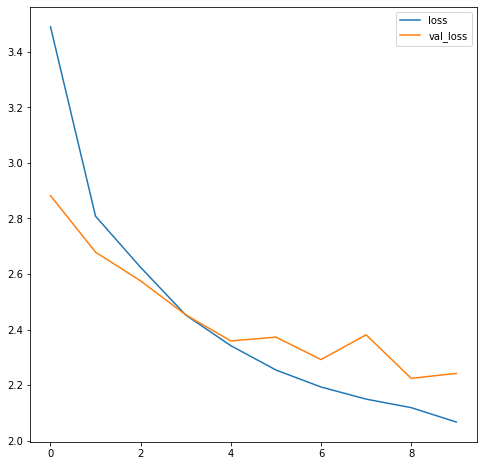

图像名: ./driving_datasets/driving_datasets/1479498504472825449.jpg

人工标注的值:

[[  1   7 143  47 164]
 [  1  45 146  69 160]
 [  1  77 146  99 159]
 [  1 114 143 137 157]
 [  1 134 146 143 156]
 [  1 141 144 155 155]
 [  1 158 145 175 154]
 [  1 197 145 211 152]
 [  1 208 143 218 151]
 [  1 223 143 233 151]
 [  1 241 137 269 163]
 [  1 282 142 294 151]
 [  1 294 141 303 149]
 [  1 311 140 320 148]
 [  1 438 132 479 147]
 [  2 184 131 208 154]
 [  2 359 131 410 140]]
预测值:

   类别   概率 xmin   ymin   xmax   ymax
[[  1.     1.   236.28 137.55 270.96 161.4 ]
 [  1.     0.98  11.38 141.26  52.21 161.78]
 [  1.     0.68  82.5  145.98  98.1  160.18]
 [  1.     0.64 159.24 143.11 175.71 156.32]
 [  1.     0.62 254.53 139.16 270.47 155.34]
 [  1.     0.61   7.31 146.05  35.75 164.78]
 [  1.     0.6  122.15 144.06 138.33 156.95]
 [  1.     0.5  179.54 134.58 201.39 152.17]]


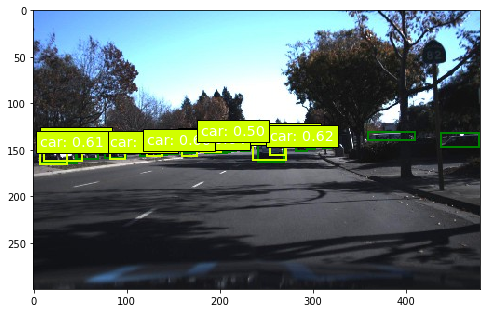

In [7]:
# 
# 训练一个 SSD 网络用于识别车载摄像头捕捉的图像中的目标
# 

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
from keras import callbacks
#from models.keras_ssd import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

# ## 1. 设置模型参数
#
# 这些参数同时需要在 `build_model()` 和 `SSDInputEncoder` 的构造函数中使用
# 
# 
# * 设置图像的高度, 宽度, 和色彩通道数量
# * 设置正样本类别个数 (不包括背景).
# * `mode` 用于 `build_model()` 函数, 决定是否使用 `DecodeDetections` 层作为最后一层. Mode 的值为 'training' 时,
# * 网络输出原始预测值. 当值为 'inference' 或者 'inference_fast' 时, 原始的输出被转为了绝对坐标, 使用了概率筛选, 使用
# * 了 non-maximum suppression, 以及 top-k 筛选. 'inference' 使用了原始Caffe实现的算法, 'inference_fast' 使用了
# * 更快, 但是相对不太精确的算法 
# * 本例子只有 4 个预测层, 但是需要 5 个 scaling factors. 因为最后一个 scaling factor 被用于计算最后一层的第二个长宽比为 1 的 Anchor 的尺寸.
# * `build_model()` 与 `SSDInputEncoder` 有两个 Anchor 的长宽比: `aspect_ratios_global` 和 `aspect_ratios_per_layer`. 
# * 你只需要设置其中一个. 如果你想使用 `aspect_ratios_global`, 设置其值为一个Python list, 这个值会被每一层使用. 
# * 如果想使用`aspect_ratios_per_layer`, 设置其值为包含 Python list 的 Python list. 每一个 list 包含每一层的 长宽比.
# * 如果 `two_boxes_for_ar1 == True`, 那么预测层为为长宽比为一的情况预测两个边界框, 一个大一些, 一个小一些
# * 如果 `clip_boxes == True`, 那么 Anchor 会被剪切到图像边界内, 建议设置为 False.
# * 在训练的时候, 边界框相对于 Anchor 的偏置需要除以 variances, 设置为 1.0, 相当于没有使用. 使用小于 1.0 的值, 相当于使得这个维度的分布值变大. 
# * `normalize_coords` 为 True 的时候, 会将所有绝对坐标值转换为相对于图像宽度和高度的值. 这个设置不影响最终的输出.

img_height = 300 # 图像的高度
img_width = 480 # 图像的宽度
img_channels = 3 # 图像的通道数
intensity_mean = 127.5 # 用于图像归一化, 将像素值转为 `[-1,1]`
intensity_range = 127.5 # 用于图像归一化, 将像素值转为 `[-1,1]`
n_classes = 5 # 正样本的类别 (不包括背景)
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # Anchor 的 scaling factors. 如果设置了这个值, 那么 `min_scale` 和 `max_scale` 会被忽略
aspect_ratios = [0.5, 1.0, 2.0] # 每一个 Anchor 的长宽比
two_boxes_for_ar1 = True # 是否产生两个为长宽比为 1 的 Anchor
steps = None # 可以手动设置 Anchor 的步长, 不建议使用
offsets = None # 可以手动设置左上角 Anchor 的偏置, 不建议使用
clip_boxes = False # 是否将 Anchor 剪切到图像边界范围内 
variances = [1.0, 1.0, 1.0, 1.0] # 可以将目标的坐标 scale 的参数, 建议保留 1.0
normalize_coords = True # 是否使用相对于图像尺寸的相对坐标


# ## 2. 创建模型
# 
# 你需要使用 2.1 创建一个新的模型, 或者使用 2.2 加载一个已经训练过的模型, 不要都使用
#
# ### 2.1 创建模型
# 
# 
# 如下代码完成 3 个任务:
# 1. 调用函数 `build_model()` 创建模型.
# 2. 可选择的加载模型权值.
# 3. 编译模型, 设置优化器 (Adam) 和损失函数 (SSDLoss) 
# 
# 1: 加载模型

K.clear_session() # 从内存中清理曾经加载的模型.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: 可选: 加载曾经的模型

#model.load_weights('./ssd_weights.h5', by_name=True)

# 3: 设置优化器和损失函数

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
# loss generator

# ### 2.2 加载一个训练好的模型
#
# 这里假设你想加载的模型是使用 'training' mode 训练的. 如果你想加载的模型是使用 'inference' 或者
# 'inference_fast' mode 训练的, 你需要在`custom_objects`添加 `DecodeDetections` 或者
# `DecodeDetectionsFast` 层.
#
# TODO: 设置要加载的模型的路径.
f = False
if f == True:
    model_path = 'ssd.h5'

    # 创建 SSDLoss 对象
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    K.clear_session() # 从内存中清理曾经加载的模型.

    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                   'compute_loss': ssd_loss.compute_loss})

#
# ## 3. 设置训练需要的 data generators
#
#%%
# 1: 初始化两个 `DataGenerator` 对象: 一个用于训练, 一个用于validation

# 可选: 如果你的电脑内存够大, 可以将所有的图像加载到内存中, 设置 `load_images_into_memory` = `True`.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: 加载数据

# TODO: 设置数据集地址.

# Images
images_dir = './driving_datasets/driving_datasets/'

# Ground truth
train_labels_filename = './driving_datasets/driving_datasets/labels_train.csv'
val_labels_filename   = './driving_datasets/driving_datasets/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # CSV 文件前 6 列的值
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# 得到训练和validation数据集的数据的量.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("训练集的图像数量:\t{:>6}".format(train_dataset_size))
print("validation集的图像数量\t{:>6}".format(val_dataset_size))


# 3: 设置 batch_size.

batch_size = 16

# 4: 定义图像增强

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# 5: 创建 encoder, 用于将人工标签转换为 SSD 损失函数需要的格式

# encoder 需要知道模型预测层输出的特征图的尺寸,用于产生 Anchor.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: 创建用于 Keras的 `fit_generator()` 的 generator.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# ## 4. 训练模型
# 
# 
# 设置 Keras callbacks. 一个用于 early stopping, 一个用于在训练看起来没有进展的情况下降低学习率,
# 一个用于保存当前最佳模型, 一个用于将训练过程的值写入 CSV 文件.
#
'''
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

 csv_logger= CSVLogger(filename='ssd8_training_log.csv',separator=',',append=True)
'''
save_best = callbacks.ModelCheckpoint('18_best.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='min')
early_stop = callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15,verbose=0,mode='auto')
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0.000001)
csv_logger= CSVLogger(filename='18.csv',separator=',',append=True)
callbacks_list = [early_stop,save_best,rl,csv_logger]


# TODO: 设置 epochs 
#initial_epoch   = 0，initial_epoch=initial_epoch
final_epoch     = 10
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              validation_data=val_generator,
                              epochs=final_epoch,verbose=1,callbacks=callbacks_list)


# 画 training and validation loss 的走势图:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()


# ### 5. 做预测
# 
# 这里我们使用已经设置好的 validation generator 做预测
# 

# 1: 初始化 generator

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)



# 2: 获取预测所需输入

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # 图像位置

print("图像名:", batch_filenames[i])
print()
print("人工标注的值:\n")
print(batch_labels[i])



# 3: 作预测

y_pred = model.predict(batch_images)

# 4: 解码 `y_pred`
# 如果我们训练是设置的是 'inference' 或者 'inference_fast' mode, 那么模型的最后一层为 `DecodeDetections` 层,
# `y_pred` 就无需解码了. 但是我们选择了 'training' mode, 模型的原始输出需要解码. 这就是 `decode_detections()` 
# 这个函数的功能. 这个函数的功能和 `DecodeDetections` 层做的事情一样, 只是使用 Numpy 而不是 TensorFlow 实现.
# (Nunpy 只能使用CPU, 而不是GPU).
# 

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("预测值:\n")
print('   类别   概率 xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])


# 最后, 我们可以将预测的边界框画在图像上. 每一个预测的边界框都有类别名称和概率显示在边上. 
# 人工标准的边界框也使用绿色的框画出来, 便于比较.

 
# 5: 在图像上画边界框 

plt.figure(figsize=(8,8))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # 设置边界框的颜色
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # 类别的名称

# 画人工标注的边界框
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# 画预测的边界框
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})


